# Download Mist Data

In [36]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [63]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [64]:
y.shape

(70000,)

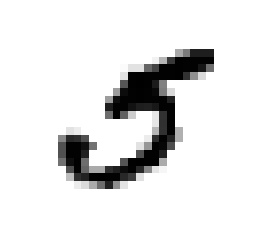

In [66]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [67]:
y[36000]

5.0

In [68]:
# MNIST dataset splits data into the first 60.000 (training set) and the last 10.000 test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [69]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary Classifier

In [70]:
# Let's simplify things by identifying one digit. The following 5-detector is a binary classifier that is
# capable of distinguishing between to classes; 5 or not-5
y_train_5 = (y_train == 5) # true for all 5s false for all other digits
y_test_5 = (y_test == 5)

In [71]:
# Let's pick a classifier and train it. A good place to start is Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [72]:
sgd_clf.predict([some_digit])

array([False], dtype=bool)

In [73]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96495,  0.95375,  0.9652 ])

In [74]:
# The code below is doing exactly the same job as cross_val_scored
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# K-fold calidation means splitting the training set into K-folds,
# then making predictions and evaluating them on each fold using a model trained on the remaining fold
skfolds = StratifiedKFold(n_splits=3, random_state=42)

#At each iteration the code 
# 1. creates a clone of the classifier
# 2. trains that clone on the training folds
# 3. makes prediction on the test fold
# 4. counts the number of correct predictions and outputs the ratio of correct prediction
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96495
0.95375
0.9652


In [75]:
# Let's create a custom dumb classifier that just classifies every single image in the not-5 class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [76]:
# What is the accuracy of this model?
never_5_clf = Never5Classifier()

In [77]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# The accuracy is high because only 10% of the images are 5s, so if you always guess that image is not-5 
# then the accuracy based on the dataset, will be 90%.
# This is the reason why accuracy is not the preferred performance measure for calssifiers,
# esspecially when the we have skewed datasets, that is when some classes are much more frequent than others

array([ 0.9078 ,  0.911  ,  0.91015])

In [78]:
# Similar to cross_val_score but returns the predictions made on each test fold
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [79]:
# A much better way to evaluate the performance of a classifier is to look 
# at the confusion matrix (counts the numner of times instances of class A are classified as class B)
# for example, to know the number of times the classifier confused images of 5s with 3s we need to look
# in the 5th row and the 3rd column of the matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

# Each row in a confusion matrix represents an actual class and each column represents a predicted class
# The first row in the following matrix considers non-5s (negative class) while the second represents the 5s class
# 54170 of the non-5s were correclty predicted as non-5s (true negatives) while 409 of the non-5s were incorectly
# predicted as 5-s (false positives). Similarly 1884 of the 5s were in-correclty predicted as non-5s (false negative) 
# and 3537 were classified correclty as 5s (true positive)

array([[53802,   777],
       [ 1545,  3876]])

In [80]:
# Precision is the accuracy of positive predictions i.e. precision = TP / TP + FP
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.83301096067053515

In [81]:
# Recall or True Positive Rate is the ratio of positive instances that are correctly detected by the classifier
# recall = TP / TP + FN
recall_score(y_train_5, y_train_pred)

0.71499723298284446

In [82]:
# A combination of precision and recall 
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.76950565812983918

In [83]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-55739.06516644])

In [84]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [85]:
y_some_digit_pred

array([False], dtype=bool)

In [86]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [87]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [88]:
y_scores.shape

(60000, 2)

In [89]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [90]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

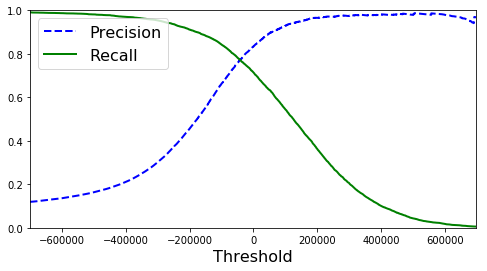

In [91]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

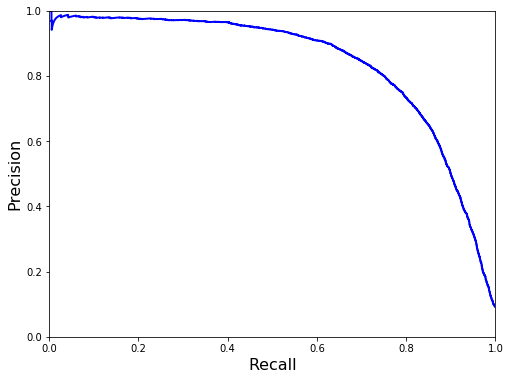

In [92]:

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# ROC curves

In [94]:
# Similar to precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots
# the true positive rate (recall) against the false positive rate
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

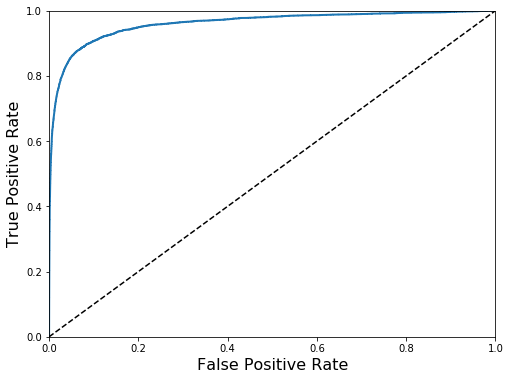

In [95]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [96]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96057288937505725

In [98]:
# The predict_proba retursn a row an array containing a row per instance
# and a column per class, each containing the probability that the given instance 
# belongs to the given class (e.g. 70% chance that the image represents a 5)
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [99]:
y_probas_forest

array([[ 0.2,  0.8],
       [ 0.9,  0.1],
       [ 1. ,  0. ],
       ..., 
       [ 1. ,  0. ],
       [ 0. ,  1. ],
       [ 1. ,  0. ]])

In [100]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [101]:
y_scores_forest 

array([ 0.8,  0.1,  0. , ...,  0. ,  1. ,  0. ])

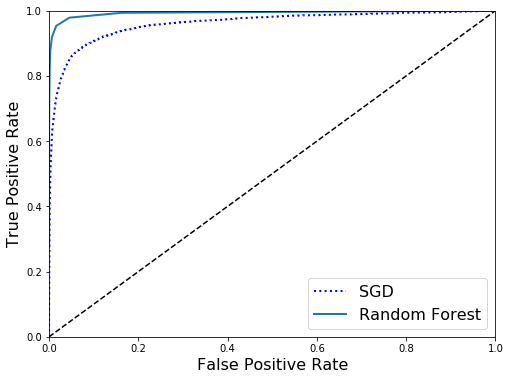

In [102]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [105]:
roc_auc_score(y_train_5, y_scores_forest)

0.99298435243915106

In [106]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.98292304280328235

In [107]:
recall_score(y_train_5, y_train_pred_forest)

0.8175613355469471

# Multiclass classification

In [110]:
# Scikit-Learn detect when you try to use a binary classification algorithm
# for a multiclass task and it automatically runs OvA (one versus all). Under the hood
# Scikit-Learn trained 10 binary classififers, got their decision scores for the image
# and selected the class with the highest score
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [113]:
# The highest score is indeed the one corresponding to class 5
some_digit_scores = sgd_clf.decision_function([some_digit])
np.argmax(some_digit_scores)

5

In [114]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [115]:
# Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly
# classify instances into multiple classes
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [116]:
# You can call predict_proba() to get the list of prababilities the classifier
# assigned to each class
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0. ,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]])

In [117]:
# Now you want to evaluate these classifiers. As usual wou want to use cross-validation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86062787,  0.86319316,  0.86292944])

In [118]:
# We can improve this accuracy by simply scaling the input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91026795,  0.90629531,  0.91348702])

# Multilabel classification

In [119]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [121]:
y_train_large

array([False, False, False, ...,  True, False,  True], dtype=bool)

In [123]:
y_train_odd

array([ True, False, False, ...,  True,  True,  True], dtype=bool)

In [124]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ..., 
       [ True,  True],
       [False,  True],
       [ True,  True]], dtype=bool)

In [125]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)